In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [5]:
from ner.evaluating_confidence import load_generated_data_for_confidence


all_data = load_generated_data_for_confidence()
points = [] # (right/false, confidence)
for data_point in all_data:
    for entity_point in data_point['logits_for_tags'] :
        if entity_point['gold tag'] != 'None':
            logits = list(entity_point['tags_logits'].values())
            max_logit = np.max(logits)
            min_logit = np.min(logits)
            for i, tag in enumerate(['PER', 'ORG', 'LOC', 'MISC']):
                points.append({
                    "target" : 1 if entity_point['gold tag'] == tag else 0,
                    "tag" : tag,
                    "gold_tag" : entity_point['gold tag'],
                    "logit" : logits[i],
                    "logit_min" : logits[i] - min_logit,
                    "logit_max" : logits[i] - max_logit
                }
            )
df = pd.DataFrame.from_dict(points)

In [13]:
mod = smf.logit(formula='target ~ C(tag) + logit + logit_min + logit_max ', data=df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.310038
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  824
Model:                          Logit   Df Residuals:                      817
Method:                           MLE   Df Model:                            6
Date:                Wed, 15 Nov 2023   Pseudo R-squ.:                  0.4487
Time:                        11:03:57   Log-Likelihood:                -255.47
converged:                       True   LL-Null:                       -463.36
Covariance Type:            nonrobust   LLR p-value:                 1.127e-86
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0864      1.476     -0.736      0.462      -3.979       1.806
C(tag)[T.MISC]   

## Model 1 : Training a model using sklearn LogisticRegression

Based on logit tag, logit_max logit_low, tell me if this tag is the right one predicted.

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from ner.evaluating_confidence import load_generated_data_for_confidence


all_data = load_generated_data_for_confidence()
points = [] # (right/false, confidence)
for data_point in all_data:
    for entity_point in data_point['logits_for_tags'] :
        if entity_point['gold tag'] != 'None':
            logits = list(entity_point['tags_logits'].values())
            max_logit = np.max(logits)
            min_logit = np.min(logits)
            for i, tag in enumerate(['PER', 'ORG', 'LOC', 'MISC']):
                points.append({
                    "target" : 1 if entity_point['gold tag'] == tag else 0,
                    "tag" : tag,
                    "gold_tag" : entity_point['gold tag'],
                    "logit" : logits[i],
                    "logit_min" : logits[i] - min_logit,
                    "logit_max" : logits[i] - max_logit
                }
            )
df = pd.DataFrame.from_dict(points)

# Assuming df is your DataFrame with columns including 'target', 'tag', 'logit', 'logit_min', 'logit_max'

# Separate features (X) and target variable (y)
X = df[['tag', 'logit', 'logit_min', 'logit_max']]
y = df['target']

# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X, columns=['tag'], drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
proba_predictions = model.predict_proba(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Additional evaluation metrics
print(classification_report(y_test, y_pred))

Accuracy: 0.92
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       120
           1       0.86      0.82      0.84        45

    accuracy                           0.92       165
   macro avg       0.90      0.89      0.89       165
weighted avg       0.91      0.92      0.91       165



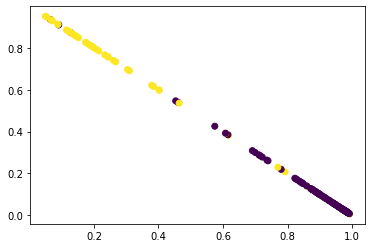

In [21]:
p_false = [p[0] for p in proba_predictions]
p_true = [p[1] for p in proba_predictions]

plt.scatter(p_false, p_true, c = y_test)

## Model 2 : Asking fo the confidence in the max token

In [42]:
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from ner.evaluating_confidence import load_generated_data_for_confidence


all_data = load_generated_data_for_confidence()
points = [] # (right/false, confidence)
for data_point in all_data:
    for entity_point in data_point['logits_for_tags'] :
        if entity_point['gold tag'] != 'None':
            logits = list(entity_point['tags_logits'].values())
            max_logit = np.max(logits)
            min_logit = np.min(logits)
            points.append({
                "target" : 1 if entity_point['gold tag'] == entity_point['outputted_tag'] else 0,
                "tag" : entity_point['outputted_tag'],
                "logit_PER" : logits[0],
                "logit_ORG" : logits[1],
                "logit_LOC" : logits[2],
                "logit_MISC" : logits[3],
                # "logit_None" : logits[4],
                "logit_min" : min_logit,
                "logit_max" : max_logit
            }
            )
df = pd.DataFrame.from_dict(points)

# Assuming df is your DataFrame with columns including 'target', 'tag', 'logit', 'logit_min', 'logit_max'

# Separate features (X) and target variable (y)
X = df[['tag', "logit_PER", "logit_ORG", "logit_LOC", "logit_MISC", 'logit_min', 'logit_max']]
y = df['target']

# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X, columns=['tag'], drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)  # apply scaling on training data
pipe.score(X_test, y_test)  

# Make predictions on the test set
y_pred = pipe.predict(X_test)
proba_predictions = pipe.predict_proba(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Additional evaluation metrics
print(classification_report(y_test, y_pred))

Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.97      0.91      0.94        35

    accuracy                           0.90        42
   macro avg       0.82      0.89      0.85        42
weighted avg       0.92      0.90      0.91        42



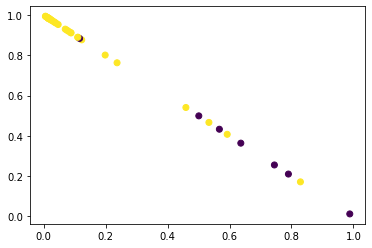

In [43]:
p_false = [p[0] for p in proba_predictions]
p_true = [p[1] for p in proba_predictions]

plt.scatter(p_false, p_true, c = y_test)

(array([ 1.,  1.,  2.,  1.,  4.,  1.,  0.,  1.,  5., 26.]),
 array([0.01168199, 0.10998772, 0.20829345, 0.30659917, 0.4049049 ,
        0.50321063, 0.60151635, 0.69982208, 0.7981278 , 0.89643353,
        0.99473926]),
 <BarContainer object of 10 artists>)

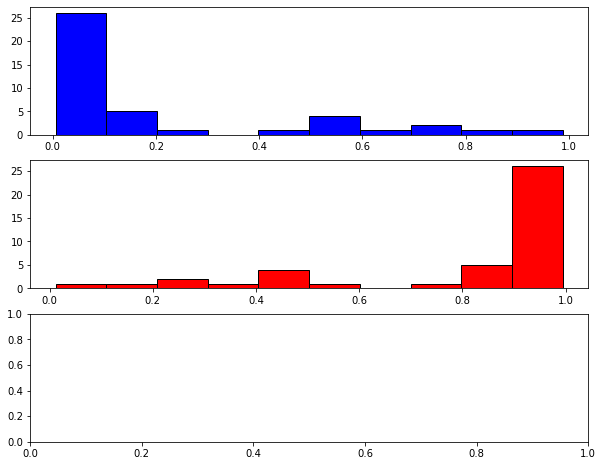

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8) )#, sharex=True, sharey=True)

# Plotting histograms for True and False values
ax1.hist(p_false, color='blue', edgecolor='black')
ax2.hist(p_true, color='red', edgecolor='black')

In [45]:
# Create a DataFrame with feature names and coefficients
coefficients_df = pd.DataFrame(data=model.coef_, columns=X.columns)

# Display the DataFrame
print("Coefficients DataFrame:")
print(coefficients_df)

Coefficients DataFrame:
   logit_PER  logit_ORG  logit_LOC  logit_MISC  logit_min  logit_max  \
0   0.076987   0.175316  -0.110547   -0.277123   0.287049  -0.269294   

   tag_MISC  tag_None   tag_ORG   tag_PER  
0 -0.033548 -1.092345 -2.399437  1.276509  


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

from ner.evaluating_confidence import load_generated_data_for_confidence


In [6]:
all_data[0]

{'data_point_idx': '0',
 'spans': [['JAPAN', 'LOC'], ['CHINA', 'PER']],
 'logits_for_tags': [{'entity': ('Japan', 'LOC'),
   'gold tag': 'LOC',
   'outputted_tag': 'LOC',
   'tags_logits': {'PER': 14.58165168762207,
    'ORG': 12.636054992675781,
    'LOC': 16.61681365966797,
    'MISC': 12.887547492980957,
    'None': 13.413434028625488},
   'confidence': {'PER': 0.10763013730626471,
    'ORG': 0.015380554243304057,
    'LOC': 0.8237463600457737,
    'MISC': 0.019778520000346703,
    'None': 0.03346442840431089}},
  {'entity': ('China', 'LOC'),
   'gold tag': 'PER',
   'outputted_tag': 'LOC',
   'tags_logits': {'PER': 14.925336837768555,
    'ORG': 14.356271743774414,
    'LOC': 19.757312774658203,
    'MISC': 16.524211883544922,
    'None': 13.688724517822266},
   'confidence': {'PER': 0.0075607221377126735,
    'ORG': 0.004279780026078898,
    'LOC': 0.9485577217806506,
    'MISC': 0.03740639773662025,
    'None': 0.002195378318937564}}]}

In [8]:
all_data = load_generated_data_for_confidence()
output = []
for dp in all_data:
    for ent in dp['logits_for_tags']:
        output.append(list(ent['tags_logits'].values())+[ent['gol']])

In [9]:
output[0]

[14.58165168762207,
 12.636054992675781,
 16.61681365966797,
 12.887547492980957,
 13.413434028625488,
 {'PER': 14.58165168762207,
  'ORG': 12.636054992675781,
  'LOC': 16.61681365966797,
  'MISC': 12.887547492980957,
  'None': 13.413434028625488}]

In [ ]:

# Load your dataset
# df = pd.read_csv('your_dataset.csv')

# Assuming you have a dataframe 'df' with columns: feature_1, feature_2, feature_3, feature_4, feature_5, label

# Split the data into features (X) and labels (y)
X = df[['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']]
y = df['label']

# Convert labels to categorical (one-hot encoding)
y_categorical = to_categorical(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build a simple neural network
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(5,)))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
y_pred_classes = [int(i) for i in y_pred.argmax(axis=-1)]
y_test_classes = [int(i) for i in y_test.argmax(axis=-1)]

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f'Test accuracy: {accuracy}')
